# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 9.51

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [530]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [531]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [532]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: predict_proba возвращает оценки вероятности для тестовых векторов X

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [533]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


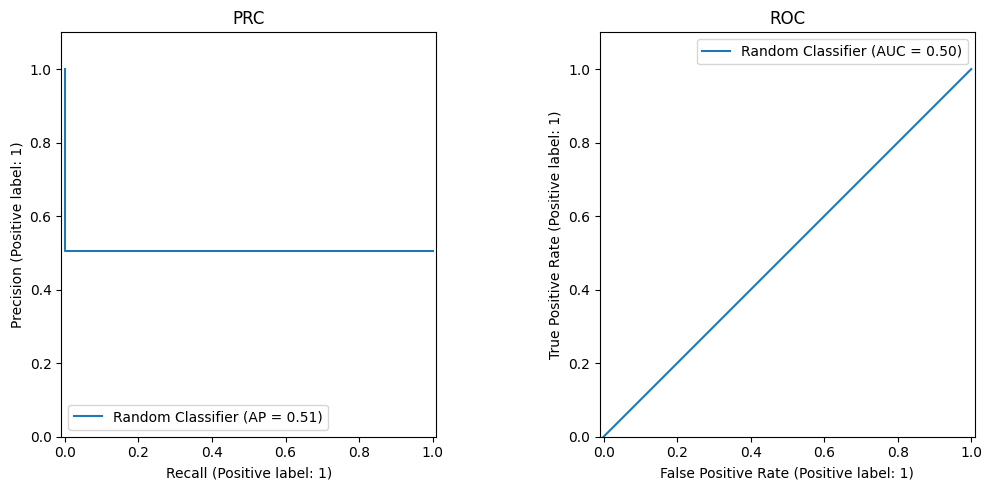

In [534]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [535]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [536]:
from sklearn.model_selection import validation_curve
from sklearn.svm import LinearSVC
import numpy as np

model_LinearSVC = LinearSVC(penalty="l2", dual=False,  max_iter=10000) # dual=False тк n_sample > n_feature

C = np.logspace(-8, 4, 11)

train_scores, test_scores = validation_curve(
    model_LinearSVC,
    X_train,
    y_train,
    param_name="C",
    param_range=C,
    scoring="average_precision", # AUC-PR
    n_jobs=2
)
mean_test_scores = test_scores.mean(axis=1)
best_C = C[np.argmax(mean_test_scores)]
model_LinearSVC.set_params(C=best_C)
model_LinearSVC.fit(X_train, y_train)
y_linearSVC = model_LinearSVC.predict(X_test)
print(f"Лучшее значение C: {best_C}")

Лучшее значение C: 3.9810717055349695e-05


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

LinearSVC with best C metrics
AUC-PR: 0.7101
AUC-ROC: 0.7590


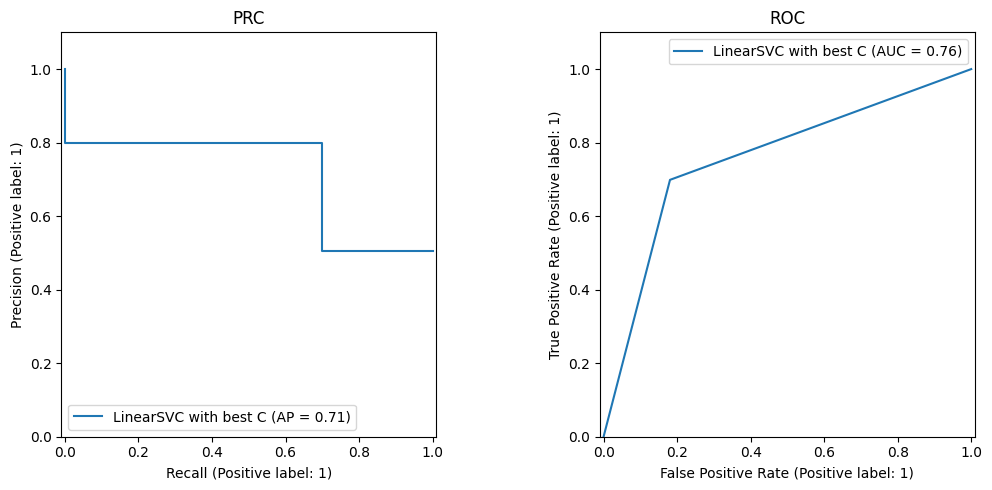

In [537]:
depict_pr_roc(y_test, y_linearSVC, 'LinearSVC with best C')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

При увеличении порога полнота уменьшается, т.e. модель начинает распознавать меньше положительных примеров. TP снижается, а FP увеличивается, т.к. сложнее правильно классицифировать положительные примеры. Модель плохо различает положительные и отрицательные примеры.


Кривая PRC немонотонна, что говорит о том, что в модели есть недостаточно уверенные предсказания. ROC монотонна, что логично, т.к. на каждом пороге увеличивается либо TP, либо FP, либо оба.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [538]:
df_metrics.loc['LinearSVC with best C'] = [
      average_precision_score(y_test, y_linearSVC),
      roc_auc_score(y_test, y_linearSVC),
      best_C,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.00000
LinearSVC with best C,0.710069,0.759016,0.00004


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



Лучшее значение C: 0.000630957344480193
LogisticRegression with best C metrics
AUC-PR: 0.7115
AUC-ROC: 0.7684


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
LinearSVC with best C,0.710069,0.759016,0.000040
LogisticRegression with best C,0.711546,0.768406,0.000631


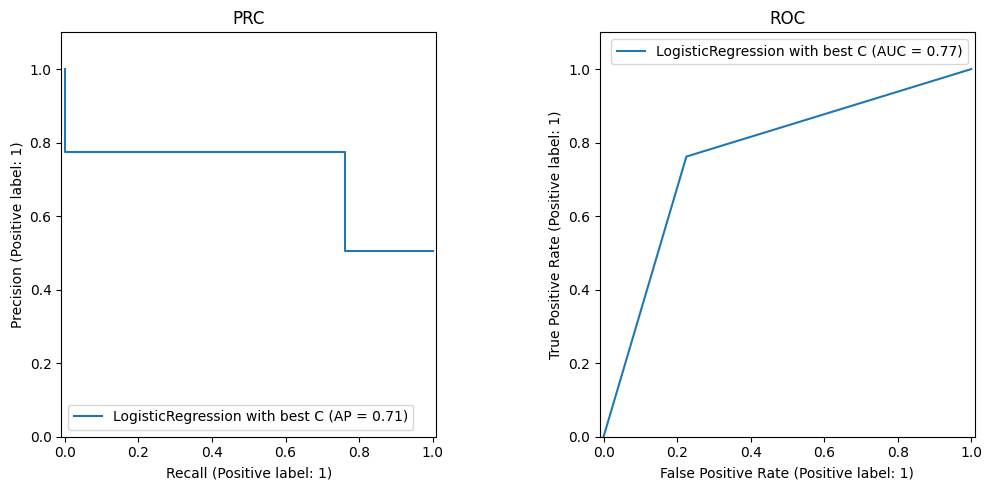

In [539]:
from sklearn.linear_model import LogisticRegression

model_Logistic= LogisticRegression(penalty="l2", dual=False,  max_iter=10000) # dual=False тк n_sample > n_feature

C_logistic = np.logspace(-8, 4, 11)

train_scores, test_scores = validation_curve(
    model_Logistic,
    X_train,
    y_train,
    param_name="C",
    param_range=C_logistic,
    scoring="average_precision", # AUC-PR
    n_jobs=2
)
mean_test_scores = test_scores.mean(axis=1)
best_C_logistic = C_logistic[np.argmax(mean_test_scores)]
model_Logistic.set_params(C=best_C_logistic)
model_Logistic.fit(X_train, y_train)
y_logistic = model_Logistic.predict(X_test)
print(f"Лучшее значение C: {best_C_logistic}")

depict_pr_roc(y_test, y_logistic, 'LogisticRegression with best C')

df_metrics.loc['LogisticRegression with best C'] = [
      average_precision_score(y_test, y_logistic),
      roc_auc_score(y_test, y_logistic),
      best_C_logistic,
]
df_metrics

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random: AUC-PR = 0.5057
LinearSVC: AUC-PR = 0.7101
LogisticRegression: AUC-PR = 0.7115
Random: AUC-ROC = 0.5000
LinearSVC: AUC-ROC = 0.7590
LogisticRegression: AUC-ROC = 0.7684


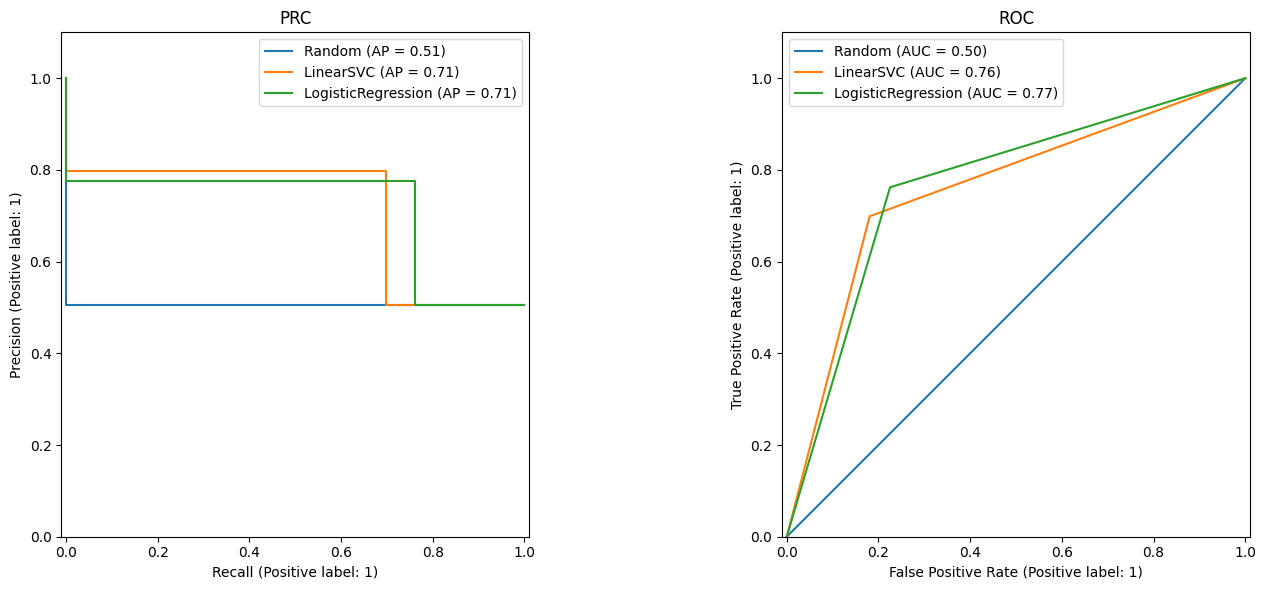

In [540]:
def depict_pr_roc_cooler(y_true, predictions, classifier_names, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    for y_pred, name in zip(predictions, classifier_names):
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=name)
        print(f"{name}: AUC-PR = {average_precision_score(y_true, y_pred):.4f}")
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    ax[0].legend()
    
    for y_pred, name in zip(predictions, classifier_names):
        RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=name)
        print(f"{name}: AUC-ROC = {roc_auc_score(y_true, y_pred):.4f}")
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

depict_pr_roc_cooler(y_test, [y_random, y_linearSVC, y_logistic], ["Random", "LinearSVC", "LogisticRegression"])

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** AP у LR и SVM совпадают, но при этом у LR полнота больше и меньше точность, но незначително. AUC у LR на 0.01 больше, чем у SVM, что говорит, о том что он лучше справляется с разделением классов. Так же LR показывает большое значение TP. Возможно это потому что LR оптимизирует вероятности, а не только расстояние до разделяющей плоскости, как SVM.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [541]:
X2, y2 = make_classification(
    n_samples=1000, n_features=2,  n_informative=2, n_redundant=0,  random_state=42
)
model_12 = LinearSVC(penalty="l2", dual=False)
model_12.fit(X2, y2)

LinearSVC(dual=False)

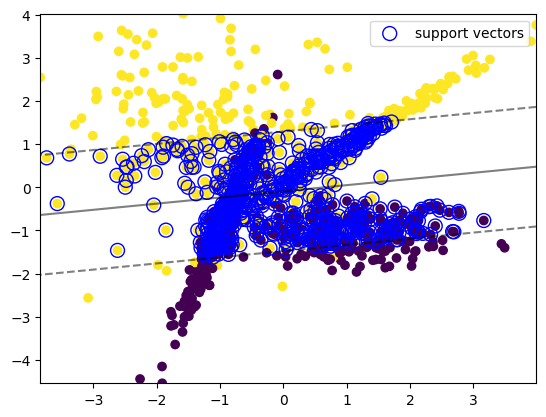

In [542]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape) 

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c = y
    )

    # Отрисовали опорные векторы
    if plot_support:
        decision_function = model.decision_function(X)
        support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
        support_vectors = X[support_vector_indices]
        plt.scatter(
            support_vectors[:, 0],
            support_vectors[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X2, y2, model_12)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те объекты, которые оказывают наибольшее влияние на расположение разделяющей гиперплоскости 

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

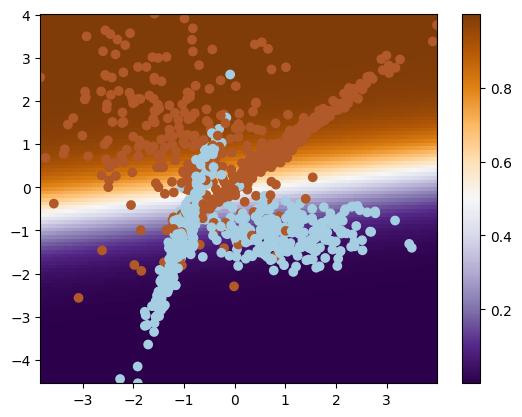

In [543]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1] 
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
       X[:, 0], X[:, 1], cmap=plt.cm.Paired, c = y
    )

    plt.colorbar(image)

model_12logistic = LogisticRegression(penalty="l2", dual=False)
model_12logistic.fit(X2, y2)
plot_logreg_2D(X2, y2, model_12logistic)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** эта область соответствует белой полосе на графике. Если ($p(y=+1|x) = 0.5$), то ($p(y=-1|x) = 0.5$), что характерно разделяющей прямой

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [544]:
def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # l + r
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # mean
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(label)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

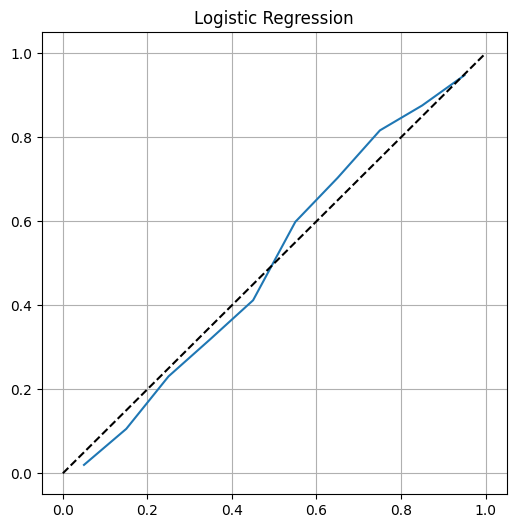

In [545]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model_Logistic.fit(X_train, y_train)
probs_logistic = model_Logistic.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probs_logistic, label="Logistic Regression")

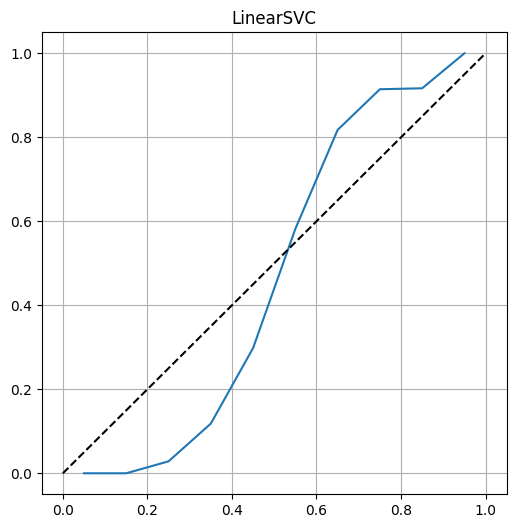

In [546]:
model_LinearSVC.fit(X_train, y_train)
decision_scores = model_LinearSVC.decision_function(X_test)

# преобразование в диапазон [0, 1]
min_score = decision_scores.min()
max_score = decision_scores.max()
probs = (decision_scores - min_score) / (max_score - min_score)

plot_calibration_curve(y_test, probs, "LinearSVC")

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Логистическая регрессия откалибрована хорошо, т.к. близка к диагонали, т.е. доли единичных ответов совпадают с предсказанными значениями. SVM же плохо откалиброван, т.к. сильно отклоняется от даигонали.  

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [547]:
from sklearn.metrics import brier_score_loss, log_loss

logloss_svc = log_loss(y_test, probs)
logloss_log = log_loss(y_test, probs_logistic)

print("LogLoss for Linear_SVC:", logloss_svc)
print("LogLoss for Logistic_Regression:", logloss_log)

brierscore_svc = brier_score_loss(y_test, probs)
brierscore_log = brier_score_loss(y_test, probs_logistic)

print("BrierScore for Linear_SVC:", brierscore_svc)
print("BrierScore for Logistic_Regression:", brierscore_log)

LogLoss for Linear_SVC: 0.5609536153696203
LogLoss for Logistic_Regression: 0.49418693382931883
BrierScore for Linear_SVC: 0.18746709009064474
BrierScore for Logistic_Regression: 0.16236185070787004


Вывод: Показания для логистической регрессии лучше(Logloss и BrierScore ниже чем у SVM), чем для Метода опорных векторов, что было ожидаемо.

Изучите распределение ответов классификаторов при помощи гистограмм

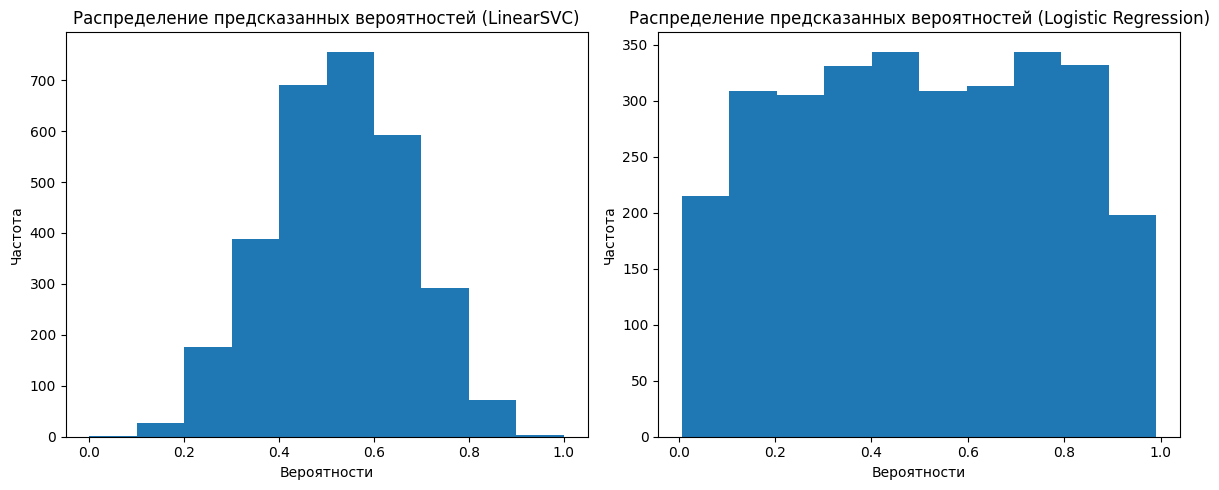

In [548]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(probs, label="LinearSVC")
plt.title("Распределение предсказанных вероятностей (LinearSVC)")
plt.xlabel("Вероятности")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
plt.hist(probs_logistic, label="Logistic Regression")
plt.title("Распределение предсказанных вероятностей (Logistic Regression)")
plt.xlabel("Вероятности")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** В LinearSVC распределение в основном около 0.5, что говорит о неуверенности предсказаний, в то время как Logistic Regression более равномерное, т.к. предсказания более уверенные. Помимо того что Логистическая регрессия еще оптимизирует вероятностьб возможно причина для такой разницы может быть в том, что в методе опорных векторов используется функция decision_function которая возвращает расстояние до гиперплоскости и потом масштабируется в вероятности, в то время как в логистической регресси используется predict_proba, которая сразу возвращает вероятность.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

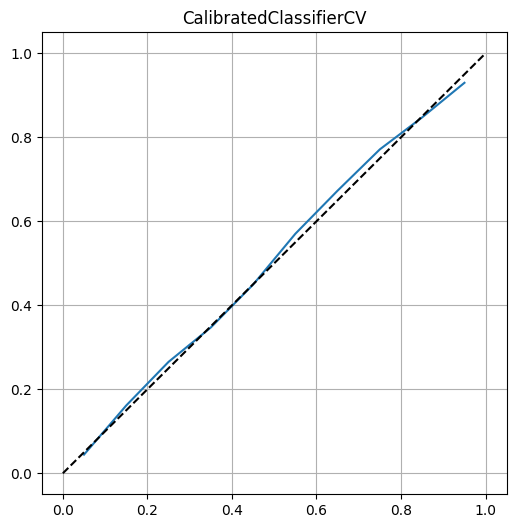

In [549]:
from sklearn.calibration import CalibratedClassifierCV

model_svm_calibrated = CalibratedClassifierCV(model_LinearSVC)
model_svm_calibrated.fit(X_train, y_train)
probs_calibr = model_svm_calibrated.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, probs_calibr, "CalibratedClassifierCV")

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Кривая стала близка к диагонали, а значит и качество калибровки тоже улучшилось.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

BrierScore for Platt: 0.16172546776174726
LogLoss for Platt: 0.4919844225711592


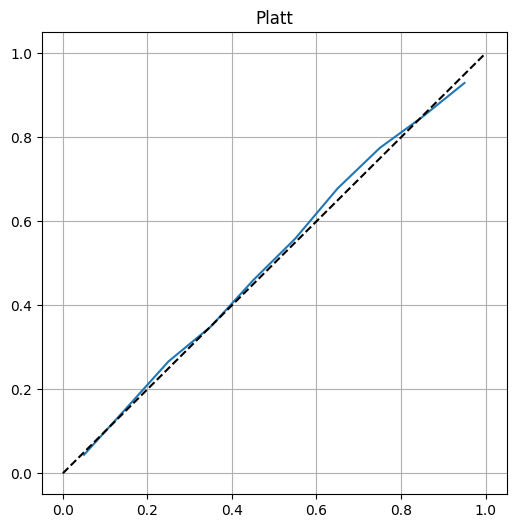

In [550]:
def platt(X_train_raw, y_train, X_test_raw):
    # обучаем логистическую регрессию на предсказаниях
    platt_model = LogisticRegression()
    X_train_raw = X_train_raw.reshape(-1, 1)  # преобразуем в 2D 
    platt_model.fit(X_train_raw, y_train)
    
    # теперь применяем модель к тестовым данным
    X_test_raw = X_test_raw.reshape(-1, 1)
    calibrated_probs = platt_model.predict_proba(X_test_raw)[:, 1]
    
    return calibrated_probs


# получаем предсказания 
train_raw = model_LinearSVC.decision_function(X_train)
test_raw = model_LinearSVC.decision_function(X_test)

calibrated_probs = platt(train_raw, y_train, test_raw)

brier_score_platt = brier_score_loss(y_test, calibrated_probs)
logloss_platt = log_loss(y_test, calibrated_probs)

print("BrierScore for Platt:", brier_score_platt)
print("LogLoss for Platt:", logloss_platt)

plot_calibration_curve(y_test, calibrated_probs, "Platt")

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [551]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [552]:
# Прочитаем датасет
from sklearn.preprocessing import LabelEncoder


data = pd.read_csv(path) 

# Заменим пропуски категориальных переменных
data = data.fillna('undefined')

# Отделим X и y
y = data["Purchased Bike"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) # закодирую сразу у
X = data.drop(columns=["Purchased Bike"])

# Разделим на категориальные признаки и числовые
X_numerical = data[["ID", "Income", "Children", "Cars", "Age"]]
X_categorical = data[["Marital Status", "Gender", "Education", "Occupation", "Home Owner", "Commute Distance", "Region"]]

В начале поработаем только с категориальными признаками

In [553]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [554]:
import time
from sklearn.preprocessing import OrdinalEncoder


start_time = time.time()
# кодирование
enc = OrdinalEncoder()
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)

# обучение
model = LogisticRegression(max_iter=1000)
model.fit(X_train_enc, y_train)

finish_time = time.time()

y_pred = model.predict_proba(X_test_enc)[:, 1]

print("AUC-PR:", average_precision_score(y_test, y_pred))
print("time:", finish_time - start_time)

AUC-PR: 0.5886533539773633
time: 0.016019105911254883


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [555]:
from sklearn.preprocessing import OneHotEncoder


start_time = time.time()
# кодирование
enc = OneHotEncoder()
X_train_onehot = enc.fit_transform(X_train)
X_test_onehot = enc.transform(X_test)

# обучение
model = LogisticRegression(max_iter=1000)
model.fit(X_train_onehot, y_train)

finish_time = time.time()

y_pred = model.predict_proba(X_test_onehot)[:, 1]

print("AUC-PR:", average_precision_score(y_test, y_pred))
print("time:", finish_time - start_time)

AUC-PR: 0.6662544177340515
time: 0.030029296875


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [556]:
start_time = time.time()
# кодирование
X_categorical5 = X_categorical.copy()
X_categorical5['y'] = y
for col in X_categorical.columns:
    val = X_categorical5.groupby(col).agg({'y': 'mean'})['y']
    X_categorical5[col] = X_categorical5[col].map(val)

# обучение
X_categorical5 = X_categorical5.drop(columns='y')
X_train, X_test, y_train, y_test = train_test_split(X_categorical5, y, test_size=0.25, random_state=777, stratify=y)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

finish_time = time.time()

y_pred = model.predict_proba(X_test)[:, 1]

print("AUC-PR:", average_precision_score(y_test, y_pred))
print("time:", finish_time - start_time)

AUC-PR: 0.7054428604898514
time: 0.033791542053222656


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [557]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [558]:
start_time = time.time()
# кодирование
X_categorical6 = X_categorical.copy()
X_categorical6['y'] = y
epsilon = 0.0005  # шум
for col in X_categorical.columns:
    val =  X_categorical6.groupby(col).agg({'y': 'mean'})['y'] 
    val += np.random.normal(0, epsilon, len(val))
    X_categorical6[col] = X_categorical6[col].map(val)

# обучение
X_categorical6 = X_categorical6.drop(columns='y')
X_train, X_test, y_train, y_test = train_test_split(X_categorical6, y, test_size=0.25, random_state=777, stratify=y)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

finish_time = time.time()

y_pred = model.predict_proba(X_test)[:, 1]

print("AUC-PR:", average_precision_score(y_test, y_pred))
print("time:", finish_time - start_time)

AUC-PR: 0.7045642266142391
time: 0.028922319412231445


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** AUC-PR почти не изменился, добавление шума либо не меняет результаты, либо делает их хуже, т.к небольшой шум практически не меняет значение, а большой разрушает закономерности

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [559]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global\_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где `global_mean` — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [560]:
# кодирование
best_auc = 0
best_C = None
global_mean = y.mean()
for C in range (1, 11, 1):
    X_categorical7 = X_categorical.copy()
    X_categorical7['y'] = y
    for col in X_categorical.columns:
        val =  X_categorical7.groupby(col).agg(sum=pd.NamedAgg(column="y", aggfunc="sum"), count=pd.NamedAgg(column="y", aggfunc="count"))
        val['smoothed'] = (val['sum'] + C * global_mean) / (val['count'] + C)
        val = val.drop(columns=['sum', 'count'])
        val_dict = val.to_dict()
        X_categorical7[col] = X_categorical7[col].map(val_dict['smoothed'])

    # обучение
    X_categorical7 = X_categorical7.drop(columns='y')
    X_train, X_test, y_train, y_test = train_test_split(X_categorical7, y, test_size=0.25, random_state=777, stratify=y)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    pr = average_precision_score(y_test, y_pred)

    if pr > best_auc:
        best_auc = pr
        best_C = C

print("Best C:", best_C)
print("AUC-PR:", best_auc)

Best C: 6
AUC-PR: 0.7069927955051845


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



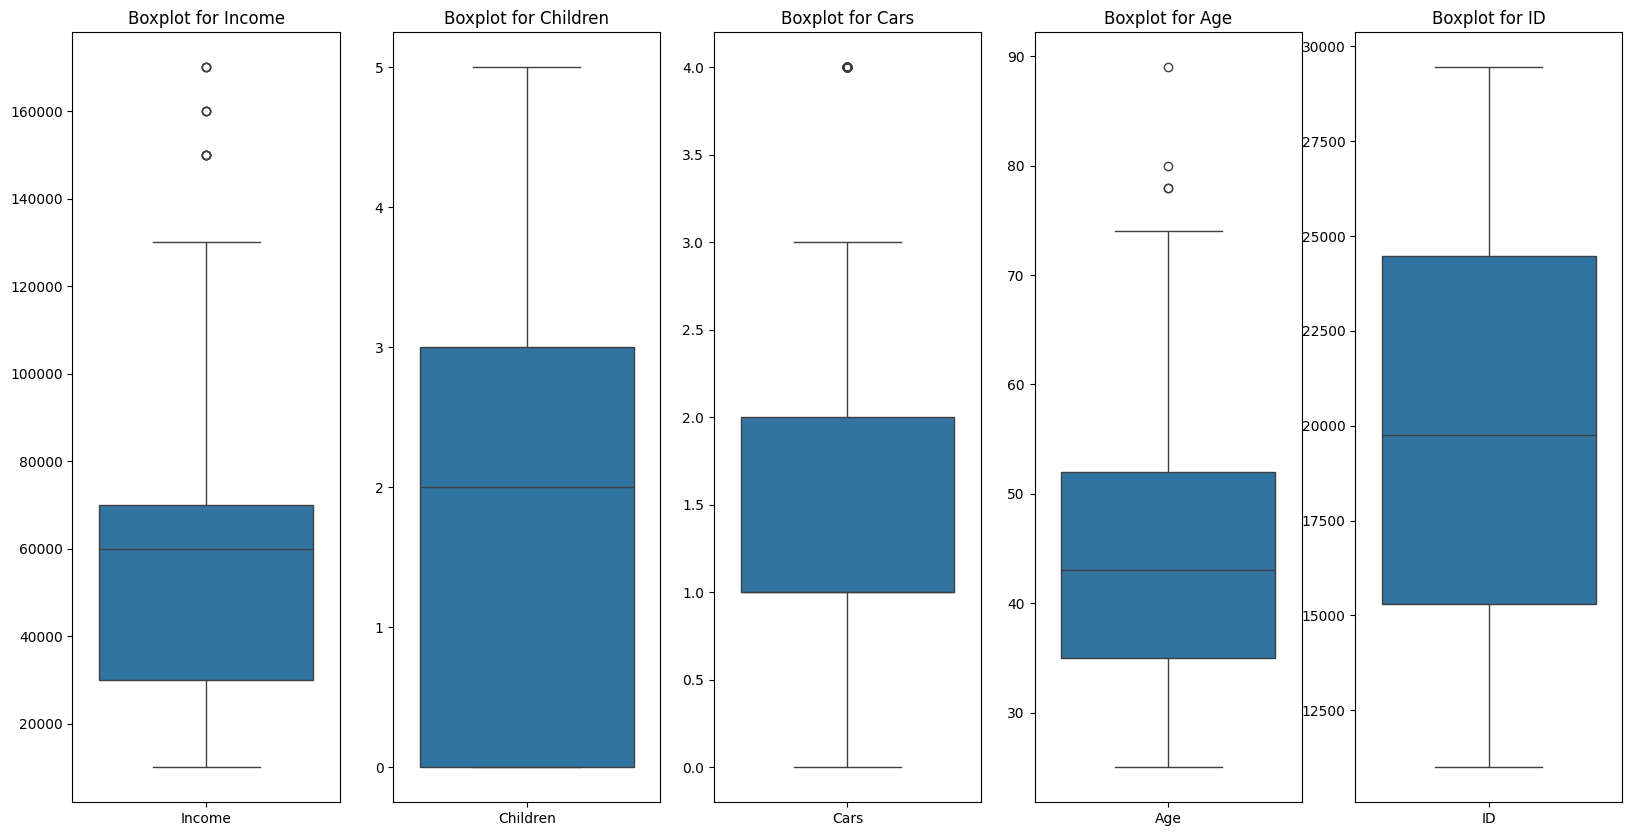

In [561]:
import seaborn as sns

plt.figure(figsize=(20, 10))
i = 1
box_plot = X_numerical.drop(columns='ID')
for col in box_plot.columns:
    plt.subplot(1, 5, i)
    sns.boxplot(box_plot[box_plot[col] != 'undefined'])
    plt.title(f'Boxplot for {col}')
    i += 1
plt.subplot(1, 5, i)
sns.boxplot(X_numerical[X_numerical['ID'] != 'undefined'])
plt.title('Boxplot for ID')
plt.show()

Выбросы есть в Age, Cars, Income, можно их удалить. Пропуски стоит заменить медианой, если данные сильно смещены, и средним значением для нормально распределенных данных. В данном случае пропуски буду заменять средним значением для cars, id, age, children, медианой: income

In [562]:
# удаляем выбросы
y = pd.Series(y).reset_index(drop=True)
delete_out = ['Age', 'Cars', 'Income']
for col in delete_out:
    need_col = X_numerical[X_numerical[col] != 'undefined'][col].reset_index(drop=True)
    Q1 = np.percentile(need_col, 25)
    Q3 = np.percentile(need_col, 75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    col_clean = need_col[(need_col >= lower_limit) & (need_col <= upper_limit)] # выбираем строки без выбросов
    X_numerical = X_numerical.loc[col_clean.index].reset_index(drop=True)
    y = y.loc[col_clean.index].reset_index(drop=True)
    # print(col_clean.index)

# заменяем значения медианой и средним значением 
mid_value_col = ['Cars', 'ID', 'Age', 'Children']
X_numerical = X_numerical.replace('undefined', np.nan)
for col in mid_value_col:
    X_numerical[col] = X_numerical[col].fillna(X_numerical[col].mean())
X_numerical['Income'] = X_numerical[col].fillna(X_numerical[col].median())

In [563]:
X_combined = pd.concat([X_categorical7, X_numerical], axis=1) # объединение с счетчиками 

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [564]:
# вычислим количество уникальных значений 
print("Количество уникальных значений: \n", X_numerical.nunique())
X_numerical = X_numerical.drop(columns='ID')
# кодирование
best_auc = 0
best_C = None
global_mean = y.mean()
for C in range (1, 11, 1):
    X_numerical8 = X_numerical.copy()
    X_numerical8['y'] = y
    for col in X_numerical.columns:
        val =  X_numerical8.groupby(col).agg(sum=pd.NamedAgg(column="y", aggfunc="sum"), count=pd.NamedAgg(column="y", aggfunc="count"))
        val['smoothed'] = (val['sum'] + C * global_mean) / (val['count'] + C)
        val = val.drop(columns=['sum', 'count'])
        val_dict = val.to_dict()
        X_numerical8[col] = X_numerical8[col].map(val_dict['smoothed'])

    # обучение
    X_numerical8 = X_numerical8.drop(columns='y')
    X_train, X_test, y_train, y_test = train_test_split(X_numerical8, y, test_size=0.25, random_state=777, stratify=y)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    pr = average_precision_score(y_test, y_pred)

    if pr > best_auc:
        best_auc = pr
        best_C = C

print("Best C:", best_C)
print("AUC-PR:", best_auc)

Количество уникальных значений: 
 ID          907
Income        7
Children      7
Cars          6
Age          54
dtype: int64
Best C: 4
AUC-PR: 0.753995813953976


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Плюсы: счетчики представляют категориальноые признаки числовыми, не увеличивая число признаков; счетчики описывают зависимость категориальных признаков от целевой переменной

Минусы: использование счетчиков может привести к переобучению; необходимость дополнительных расчетов; тяжелее понимать значимость переменных; при несбалансированных данных, могут показывать низкое качество модели

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [565]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [566]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14872,26,Private,247025,Assoc-voc,11,Divorced,Craft-repair,Own-child,White,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [567]:
y = df['income']
X = df.drop(columns='income')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [568]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)])

X_train_onehot = column_transformer.fit_transform(X_train)
X_test_onehot = column_transformer.transform(X_test)

print("Количество новых признаков:", X_train_onehot.shape[1])

Количество новых признаков: 102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [569]:
model = LogisticRegression()
model.fit(X_train_onehot, y_train)

y_pred = model.predict_proba(X_test_onehot)[:, 1]
pr = average_precision_score(y_test, y_pred)

print("AUC-PR:", pr)

AUC-PR: 0.6854009141498654


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [570]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=777, stratify=y_test)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [571]:
X_val_onehot = column_transformer.transform(X_val)

start_time = time.time()

coefficients = model.coef_[0]  
top_coeff = abs(coefficients).argsort()[-40:]
X_train_40 = X_train_onehot[:, top_coeff]
X_val_40 = X_val_onehot[:, top_coeff]

finish_time = time.time()

model_40 = LogisticRegression()

model_40.fit(X_train_40, y_train)
y_val_pred = model_40.predict_proba(X_val_40)[:, 1]
pr = average_precision_score(y_val, y_val_pred)

print("AUC-PR:", pr)
print("time:", finish_time - start_time)

AUC-PR: 0.6289661248209517
time: 0.009040355682373047


Изменилось ли качество? Как?

Качество ухудшилось на 0.06 примерно, а время уменьшилось на 0.02 секунды

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [572]:
from sklearn.preprocessing import StandardScaler


numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical),
    ('scaling', StandardScaler(), numeric)
])
X_train_scaling = column_transformer.fit_transform(X_train) # масштабирую и кодирую категориальные
X_val_scaling = column_transformer.transform(X_val)

model_scal_ohe = LogisticRegression()
model_scal_ohe.fit(X_train_scaling, y_train) # заново обучаю модель с учетом масштабирования

coefficients = model_scal_ohe.coef_[0]  
top_coeff = abs(coefficients).argsort()[-40:] # отбираю 40 наибольших по модулю коэффициентов
X_train_scal_40 = X_train_scaling[:, top_coeff]
X_val_scal_40 = X_val_scaling[:, top_coeff]

model_40 = LogisticRegression()
model_40.fit(X_train_scal_40, y_train) # заново обучаю модель с учетом масштабирования и отбирая 40 наибольших по модулю
y_val_pred = model_40.predict_proba(X_val_scal_40)[:, 1]
pr = average_precision_score(y_val, y_val_pred)

print("AUC-PR:", pr)

AUC-PR: 0.7169489960333555


Как видно качество значительно улучшилось

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [573]:
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_scaling)
X_val_scaled = scaler.transform(X_val_scaling)

model_scal_ultra = LogisticRegression()
model_scal_ultra.fit(X_train_scaled, y_train) # заново обучаю модель с учетом масштабирования

coefficients = model_scal_ultra.coef_[0]  
top_coeff = abs(coefficients).argsort()[-40:] # отбираю 40 наибольших по модулю коэффициентов
X_train_scaled_40 = X_train_scaled[:, top_coeff]
X_val_scaled_40 = X_val_scaled[:, top_coeff]

model_40 = LogisticRegression()
model_40.fit(X_train_scaled_40, y_train) # заново обучаю модель с учетом масштабирования и отбирая 40 наибольших по модулю
y_val_pred = model_40.predict_proba(X_val_scaled_40)[:, 1]
pr = average_precision_score(y_val, y_val_pred)

print("AUC-PR:", pr)

AUC-PR: 0.7465179191919448


Качество еще больше улучшилось

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Корреляция показывает, насколько сильно признак линейно связан с целевой переменной. Высокая корреляция с целевой переменной говорит о том, что признак может быть полезным для предсказания. Таким образом, исключив незначимые признаки, отбор признаков по корреляции может улучшить качество модели

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [574]:
start_time = time.time()
correlations = pd.DataFrame(X_train_scaled).corrwith(y_train) # посчитаем корреляцию

top_features = abs(correlations).argsort()[-40:] # отберем 40 признаков
X_train_corr_40 = X_train_scaled[:, top_features]
X_val_corr_40 = X_val_scaled[:, top_features]

finish_time = time.time()

model_corr = LogisticRegression()
model_corr.fit(X_train_corr_40, y_train)
y_pred = model_corr.predict_proba(X_val_corr_40)[:, 1]
pr = average_precision_score(y_val, y_pred)

print("AUC-PR:", pr)
print("time:", finish_time - start_time)

AUC-PR: 0.7022881468115282
time: 0.3790304660797119


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [575]:
start_time = time.time()

X_train_class_1 = X_train_scaled[y_train == 1] # разделяю данные по классам
X_train_class_0 = X_train_scaled[y_train == 0]

mu_1 = np.mean(X_train_class_1, axis=0) # вычисляю статистики
mu_0 = np.mean(X_train_class_0, axis=0)
sigma_1 = np.var(X_train_class_1, axis=0)
sigma_0 = np.var(X_train_class_0, axis=0)
n_1 = X_train_class_1.shape[0]
n_0 = X_train_class_0.shape[0]

t_stat = np.abs(mu_1 - mu_0) / np.sqrt((n_1 * sigma_1 + n_0 * sigma_0) / (n_1 + n_0)) # вычисляю t

top_features = np.argsort(t_stat)[-40:] # отбираю 40 признаков
X_train_t_40 = X_train_scaled[:, top_features]
X_val_t_40 = X_val_scaled[:, top_features]

finish_time = time.time()

model_t = LogisticRegression()
model_t.fit(X_train_t_40, y_train)
y_pred = model_t.predict_proba(X_val_t_40)[:, 1]
pr = average_precision_score(y_val, y_pred)

print("AUC-PR:", pr)
print("time:", finish_time - start_time)

AUC-PR: 0.7449363094638505
time: 0.034497737884521484


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [576]:
# your code here


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [577]:
# your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [578]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [579]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [580]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [581]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [582]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])
    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression()

    for train_index, test_index in kf.split(X, y):
        start_time = time.time()
        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)        
        y_pred = model.predict_proba(X_test)[:, 1]
        
        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "auc-pr" : average_precision_score(y_test, y_pred),
            "time": time.time() - start_time
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)


results = cross_validate(X, y, random_state=42, shuffle=True)
print(results)

     auc-pr      time
0  0.430575  0.468050
1  0.472704  0.480009
2  0.449904  0.440500
3  0.454720  0.458765
4  0.455306  0.409204


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [583]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])
    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression()

    for train_index, test_index in kf.split(X, y):
        start_time = time.time()
        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)        
        y_pred = model.predict_proba(X_test)[:, 1]

        profit = 0
        salary = 0
        for true, proba in zip(y_test, y_pred):
            if proba > 0.5: # пусть порог для принятия решения равен 0.5
                salary += 2
                if true == 1:  
                    profit += 8  # 10 выручки - 2 зп
                else:
                    profit -= 2 # -2 зп
        
        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "auc-pr" : average_precision_score(y_test, y_pred),
            "profit" : profit, 
            "salary" : salary,
            "time" : time.time() - start_time
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)


results = cross_validate(X, y, random_state=42, shuffle=True)
print("Средний заработок:", np.mean(results['profit']))
print("Средняя зарплата операторов:", np.mean(results['salary']))
print("Стандартное отклонение профита",np.std(results['profit']))
print("Коэффициент корреляции между качеством(AUC-PR) и прибылью", np.corrcoef(results['profit'], results['auc-pr'])[0][1])
print(results)

Средний заработок: 1486.4
Средняя зарплата операторов: 645.6
Стандартное отклонение профита 103.53279673610676
Коэффициент корреляции между качеством(AUC-PR) и прибылью 0.48261180858768443
     auc-pr  profit  salary      time
0  0.430575    1368     622  0.520617
1  0.472704    1560     650  0.427475
2  0.449904    1650     730  0.456560
3  0.454720    1414     616  0.444472
4  0.455306    1440     610  0.411662


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [584]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])
    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression()

    for train_index, test_index in kf.split(X, y):
        start_time = time.time()
        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)        
        y_pred = model.predict_proba(X_test)[:, 1]

        profit = 0
        salary = 0

        for true, proba in zip(y_test, y_pred):
            if proba > 0.5: # пусть порог для принятия решения равен 0.5
                salary += 2
                if true == 1:  
                    profit += np.random.uniform(0, 20, 1)[0]
                else:
                    profit -= 2 # -2 зп
        
        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "auc-pr" : average_precision_score(y_test, y_pred),
            "profit" : profit, 
            "salary" : salary,
            "time" : time.time() - start_time
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)


results = cross_validate(X, y, random_state=42, shuffle=True)
print("Средний заработок:", np.mean(results['profit']))
print("Средняя зарплата операторов:", np.mean(results['salary']))
print("Стандартное отклонение профита",np.std(results['profit']))
print("Коэффициент корреляции между качеством(AUC-PR) и прибылью", np.corrcoef(results['profit'], results['auc-pr'])[0][1])
print(results)

Средний заработок: 1834.5791535242865
Средняя зарплата операторов: 645.6
Стандартное отклонение профита 172.05774619490953
Коэффициент корреляции между качеством(AUC-PR) и прибылью 0.45175223238357165
     auc-pr       profit  salary      time
0  0.430575  1684.219416     622  0.497590
1  0.472704  1996.131416     650  0.429171
2  0.449904  2088.097406     730  0.482074
3  0.454720  1700.682060     616  0.342226
4  0.455306  1703.765470     610  0.357611


profit увеличился, корреляция с качеством уменьшилась, но не сильно

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

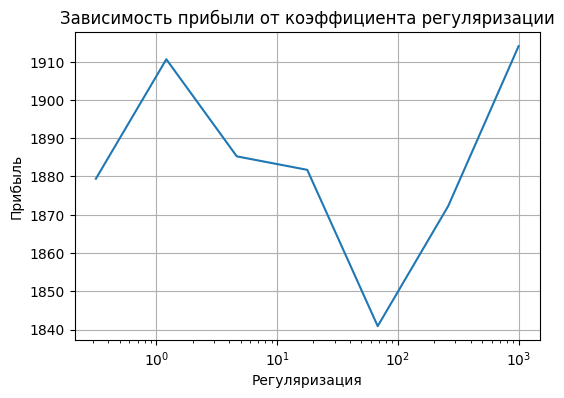

Средний заработок: 1914.0323631424333
Средняя зарплата операторов: 646.4
Стандартное отклонение профита 190.26098136803168
Коэффициент корреляции между качеством(AUC-PR) и прибылью -0.06515043354719269
     auc-pr       profit  salary      time  best_C
0  0.430596  1886.039249     630  0.359853  1000.0
1  0.472663  1935.182600     648  0.339999  1000.0
2  0.449389  2256.601188     730  0.378273  1000.0
3  0.454832  1801.196212     616  0.342136  1000.0
4  0.454948  1691.142567     608  0.317056  1000.0


In [585]:
def cross_validate_C(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    grafs=False
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    C_values=np.logspace(-0.5, 3, 7)
    metrics = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 
    best_profit = 0
    profits = []
    for C in C_values:
        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(), categorical_features),
            ('scaling', StandardScaler(), numeric_features)
        ])
        scaler = StandardScaler(with_mean=False)
        model = LogisticRegression(C=C)
        metrics_help = []

        for train_index, test_index in kf.split(X, y):
            start_time = time.time()
            # возьмите датасет и обучите модель
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            X_train = column_transformer.fit_transform(X_train)
            X_test = column_transformer.transform(X_test)        
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)        
            y_pred = model.predict_proba(X_test)[:, 1]

            profit = 0
            salary = 0

            for true, proba in zip(y_test, y_pred):
                if proba > 0.5: # пусть порог для принятия решения равен 0.5
                    salary += 2
                    if true == 1:  
                        profit += np.random.uniform(0, 20, 1)[0]
                    else:
                        profit -= 2 # -2 зп
            
        
            # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
            metric_dict = {
                "auc-pr" : average_precision_score(y_test, y_pred),
                "profit" : profit, 
                "salary" : salary,
                "time" : time.time() - start_time,
                "best_C" : C
            }
            metrics_help.append(metric_dict)

        mid_profit = np.mean(pd.DataFrame(metrics_help)['profit'])
        profits.append(mid_profit)
        if mid_profit > best_profit:
            metrics = metrics_help
            best_profit = mid_profit

    if grafs:
        # построю график зависимости прибыли от C
        plt.figure(figsize=(6, 4))
        plt.plot(C_values, profits)
        plt.xscale('log')
        plt.xlabel('Регуляризация')
        plt.ylabel('Прибыль')
        plt.title('Зависимость прибыли от коэффициента регуляризации')
        plt.grid(True)
        plt.show()    
    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)


results = cross_validate_C(X, y, random_state=42, shuffle=True, grafs=True)
print("Средний заработок:", np.mean(results['profit']))
print("Средняя зарплата операторов:", np.mean(results['salary']))
print("Стандартное отклонение профита",np.std(results['profit']))
print("Коэффициент корреляции между качеством(AUC-PR) и прибылью", np.corrcoef(results['profit'], results['auc-pr'])[0][1])
print(results)

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [586]:
num_runs = 5
best_Cs = []

for run in range(num_runs):
    print("Запуск №", run + 1)
    result = cross_validate_C(X, y, random_state=42, shuffle=True)    
    print("Лучший коэффициент регуляризации:", result['best_C'][0])
    print("Средняя прибыль:",  np.mean(result['profit']))

Запуск № 1
Лучший коэффициент регуляризации: 1000.0
Средняя прибыль: 1947.5251650040846
Запуск № 2
Лучший коэффициент регуляризации: 1000.0
Средняя прибыль: 2022.8563216457137
Запуск № 3
Лучший коэффициент регуляризации: 68.12920690579615
Средняя прибыль: 1971.268250177945
Запуск № 4
Лучший коэффициент регуляризации: 0.31622776601683794
Средняя прибыль: 1963.032198969512
Запуск № 5
Лучший коэффициент регуляризации: 1000.0
Средняя прибыль: 1980.744399764088


Каждый раз лучший коэффициент разный, закономерности не вижу, что логично, т.к. лучший С отбирается по прибыли, которая в свою очередь имеет рандомный характер, поэтому логично, что и коэффициент будет всегда разный

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Идеально найти баланс, тк низкая точность может привести к тому что затраты на звонок будут больше чем выгода из-за низкой доли согласных, при этом если будет низкая полнота, то приведет к упущенной прибыли, тк звонков будет мало. Но все же выбирая между банкротством и просто беднотой, лучше выбрать бедноту, то есть максимизировать полноту.

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [587]:
from sklearn.metrics import precision_score, recall_score, f1_score


def cross_validate_with_threasholds(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    grafs=False 
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 
    thresholds=np.arange(0.01, 1.01, 0.01)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])
    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression()
    best_profit = 0
    profits = []
    for threshold in thresholds:
        metrics_help = []
        for train_index, test_index in kf.split(X, y):
            start_time = time.time()
            # возьмите датасет и обучите модель
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            X_train = column_transformer.fit_transform(X_train)
            X_test = column_transformer.transform(X_test)        
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)        
            y_pred = model.predict_proba(X_test)[:, 1]

            y_pred = (y_pred >= threshold).astype(int) # бинаризирую предсказания

            profit = 0
            salary = 0

            for true, proba in zip(y_test, y_pred):
                if proba > 0.5: # пусть порог для принятия решения равен 0.5
                    salary += 2
                    if true == 1:  
                        profit += np.random.uniform(0, 20, 1)[0]
                    else:
                        profit -= 2 # -2 зп
            
            # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
            metric_dict = {
                "auc-pr" : average_precision_score(y_test, y_pred),
                "profit" : profit, 
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'best_threshold': threshold
            }
            metrics_help.append(metric_dict)
        
        mid_profit = np.mean(pd.DataFrame(metrics_help)['profit'])
        profits.append(mid_profit)
        if mid_profit > best_profit:
            metrics = metrics_help
            best_profit = mid_profit

    if grafs:
        plt.plot(thresholds, profits)
        plt.axvline(x=pd.DataFrame(metrics)['best_threshold'][0], color='red', linestyle='--')
        plt.xlabel('Порог бинаризации')
        plt.ylabel('Прибыль')
        plt.title('График зависимости прибыли от порога бинаризации')
        plt.show()
    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)


results = cross_validate_with_threasholds(X, y, random_state=42, shuffle=True)
print("Средний заработок:", np.mean(results['profit']))
print("Стандартное отклонение профита",np.std(results['profit']))
print("Коэффициент корреляции между качеством(AUC-PR) и прибылью", np.corrcoef(results['profit'], results['auc-pr'])[0][1])
print(results)

c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Средний заработок: 3916.510512532726
Стандартное отклонение профита 261.91213871933246
Коэффициент корреляции между качеством(AUC-PR) и прибылью 0.9098292271777624
     auc-pr       profit  precision    recall        f1  best_threshold
0  0.275755  3463.490013   0.418136  0.532620  0.468485             0.2
1  0.292983  4137.400055   0.430099  0.569717  0.490159             0.2
2  0.301109  4125.792442   0.438947  0.572320  0.496838             0.2
3  0.291934  3778.084911   0.426298  0.579727  0.491313             0.2
4  0.296399  4077.785142   0.433977  0.568565  0.492237             0.2


c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

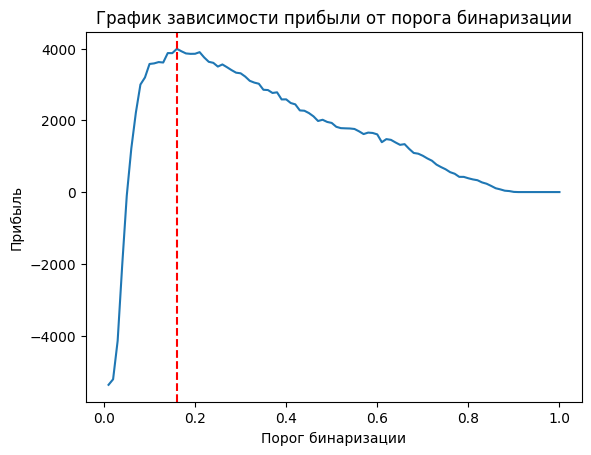

In [589]:
results = cross_validate_with_threasholds(X, y, random_state=42, shuffle=True, grafs=True)

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Ответ: порог получается низким, что говорит о том, что все таки полнота оказалась важнее, чем точность.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
from scipy.stats import ttest_rel


def cross_validate_with_threasholds_C(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) 
    thresholds=np.arange(0.01, 1.01, 0.01)
    C_values=np.logspace(-0.5, 3, 7)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ])
    scaler = StandardScaler(with_mean=False)
    best_profit = 0
    
    for C in C_values:
        model = LogisticRegression(C=C)
        for threshold in thresholds:
            metrics_help = []
            for train_index, test_index in kf.split(X, y):
                # возьмите датасет и обучите модель
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
                X_train = column_transformer.fit_transform(X_train)
                X_test = column_transformer.transform(X_test)        
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

                model.fit(X_train, y_train)        
                y_pred = model.predict_proba(X_test)[:, 1]

                y_pred = (y_pred >= threshold).astype(int) # бинаризирую предсказания

                profit = 0
                salary = 0

                for true, proba in zip(y_test, y_pred):
                    if proba > 0.5: # пусть порог для принятия решения равен 0.5
                        salary += 2
                        if true == 1:  
                            profit += np.random.uniform(0, 20, 1)[0]
                        else:
                            profit -= 2 # -2 зп
                
                # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
                metric_dict = {
                    "auc-pr" : average_precision_score(y_test, y_pred),
                    "profit" : profit, 
                    'precision': precision_score(y_test, y_pred),
                    'recall': recall_score(y_test, y_pred),
                    'f1': f1_score(y_test, y_pred),
                    'best_threshold': threshold,
                    "best_C" : C
                }
                metrics_help.append(metric_dict)
            
            mid_profit = np.mean(pd.DataFrame(metrics_help)['profit'])
            if mid_profit > best_profit:
                metrics = metrics_help
                best_profit = mid_profit

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)


result_regular = cross_validate(X, y, random_state=42, shuffle=True)
print("Средний заработок обычной модели:", np.mean(result_regular['profit']))
print("Стандартное отклонение профита",np.std(result_regular['profit']))
print(results)

results = cross_validate_with_threasholds_C(X, y, random_state=42, shuffle=True)
print("Средний заработок модели с порогом и гиперпараметром:", np.mean(results['profit']))
print("Стандартное отклонение профита",np.std(results['profit']))
print(results)

t_stat, p_value = ttest_rel(results['profit'], result_regular['profit'])

print(f"T-статистика: {t_stat:.2f}, p-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Различия в прибыли статистически значимы (отвергаем H0).")
else:
    print("Различия в прибыли не статистически значимы (не отвергаем H0).")


Средний заработок обычной модели: 1926.4130189571465
Стандартное отклонение профита 158.55041210193448
     auc-pr       profit  precision    recall        f1  best_threshold
0  0.275559  3704.407173   0.399397  0.566845  0.468612            0.17
1  0.287743  3919.767497   0.409502  0.591503  0.483957            0.17
2  0.293780  4384.259620   0.413718  0.596254  0.488491            0.17
3  0.286083  3380.161561   0.402264  0.607062  0.483886            0.17
4  0.287939  3982.238325   0.406657  0.592827  0.482403            0.17


c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Средний заработок модели с порогом и гиперпараметром: 4008.3047537680336
Стандартное отклонение профита 262.6337216680312
     auc-pr       profit  precision    recall        f1  best_threshold   
0  0.277361  4037.877163   0.405887  0.560428  0.470800            0.18  \
1  0.291362  3990.660387   0.417311  0.588235  0.488246            0.18   
2  0.292814  4347.915281   0.417346  0.585848  0.487446            0.18   
3  0.287583  3543.942750   0.408702  0.599089  0.485912            0.18   
4  0.289409  4121.128187   0.413922  0.583333  0.484238            0.18   

     best_C  
0  1.211528  
1  1.211528  
2  1.211528  
3  1.211528  
4  1.211528  
T-статистика: 16.14, p-значение: 0.0001
Различия в прибыли статистически значимы (отвергаем H0).


c:\Users\annat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 811kB/s]

Extracting files...


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

ModuleNotFoundError: No module named 'torch'

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ бутерброд с сыром и сосисками